In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap



## Pipeline
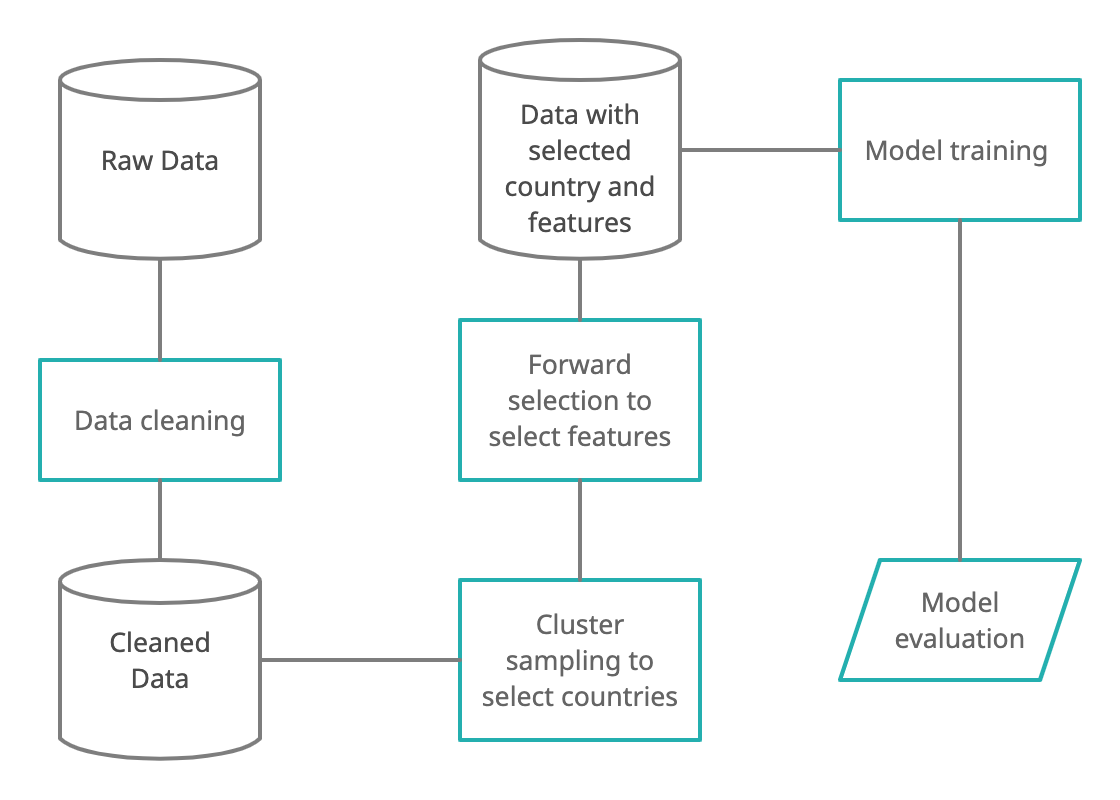

# Data preparation
The raw data for this project used is in the following link: https://github.com/owid/covid-19-data/tree/master/public/data/

In this task, we will be predicting the number of new deaths tomorrow given the data of covid-19 today.

We will first clean the data by removing wrong entries and shift the index of new death up by 1 to transform it into the new death tomorrow (since this is what we are predicting)

We will sample the dataset by cluster sampling then apply a feature selection technique to select our features.
We chose cluster sampling as our sampling technique as the covid death in different country may vary alot depending on the country. Hence,if we use all the country, the variance in the dataset will be too high

By choosing data points within a cluster, there are more 'similar' which might have more significant underlying trend and our model can learn to predict


In [2]:

np.random.seed(0)  

df = pd.read_csv('owid-covid-data.csv')
df.fillna(0,inplace = True)
df.drop(['date'],axis = 1,inplace=True) 
df = df.set_index(['location'])## set the location as the index of the dataframe so that it wouldnt be dropped 
df = df._get_numeric_data()
##drop non numermic features
df = df[(df >= 0).all(1)]   ## remove all negative entries

## Since we want to predict the new covid death tomorrow, we will have to shift the new_death columns down by 1 for each country
feature_df= pd.DataFrame()
for _,frame in df.groupby(['location']):
    target_frame = frame['new_deaths']
    target_frame = target_frame[1:]
    frame = frame.drop(columns=['new_deaths'])
    frame = frame[:-1]
    new_frame = pd.concat([target_frame,frame],axis=1)
    feature_df = pd.concat([feature_df,new_frame],axis=0)

feature_df = feature_df.rename(columns={"new_deaths": "new_deaths_tomorrow"}) ## renaming the target column
 


In [4]:
feature_df

,new_deaths_tomorrow,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
location,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,5.0,5.0,0.000,0.0,0.000,0.126,0.126,0.000,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
Afghanistan,0.0,5.0,0.0,0.000,0.0,0.000,0.126,0.000,0.000,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
Afghanistan,0.0,5.0,0.0,0.000,0.0,0.000,0.126,0.000,0.000,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
Afghanistan,0.0,5.0,0.0,0.000,0.0,0.000,0.126,0.000,0.000,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
Afghanistan,0.0,5.0,0.0,0.000,0.0,0.000,0.126,0.000,0.000,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,0.0,132588.0,48.0,43.286,4663.0,1.143,8785.217,3.180,2.868,308.968,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
Zimbabwe,6.0,132588.0,0.0,36.429,4663.0,0.857,8785.217,0.000,2.414,308.968,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
Zimbabwe,4.0,132651.0,63.0,40.429,4669.0,1.571,8789.392,4.174,2.679,309.366,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0


# Cluster sampling

In order to find the clusters in the dataset, we will first use principal components analysis (pca) for dimension reduction and data visualization.

We will use K-mean clustering on the principal components to clusters within the data point.

We then select the cluster with most country inside as our dataset for our regression model.

By choosing the cluster with most country, we will have more data points which will decrease the variance of our error in our prediction.

In [3]:
## Normalization for pca
mean = feature_df.mean(axis=0)
s = feature_df.std(axis=0)
df_normalized = (feature_df-mean)/s
X_normalized = df_normalized.to_numpy()

In [4]:
def pca(feature_vector,n_components=3):
    
    feature_vec_normalized = (feature_vector-feature_vector.mean())/feature_vector.std()
    cov = np.cov(feature_vec_normalized.T) ## covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(cov) ## find eigenvector and eigen value
    variance_explained = []
    
    for i in eigen_values:
        
         variance_explained.append((i/sum(eigen_values))*100)
            
    print('Variance explained per pca component is ', variance_explained)
    cumulative_variance_explained = [variance_explained[0]]
    
    for k in range(1,n_components):
        
        cumulative_variance_explained.append(cumulative_variance_explained[k-1]+variance_explained[k])
        
    projection_matrix = (eigen_vectors.T[:][:n_components]).T
    X_pca = feature_vector.dot(projection_matrix) ### Project the original dataset into a lower dimension
    
    print("Cumulative_variance_explained for {} components is {}: "
          .format(n_components,cumulative_variance_explained))
    
    return X_pca, cumulative_variance_explained

In [5]:
def compute_distance(cluster_num,point):
    return np.sum((cluster_num-point)**2)

def total_cost(clusters,cluster_assigned,feature_vector):
    J = 0
    for i in range(len(clusters)):
        cluster_data = feature_vector[cluster_assigned==i]
        J+=np.sum((clusters[i]-cluster_data)**2)
    return J
    
def assign_clusters(clusters,feature_vector): ## Assigning each point to a cluster number
    n_clusters = clusters.shape[0]
    n_feature = feature_vector.shape[0]
    cluster_assigned = np.zeros(n_feature)
    for j in range(n_feature):
        dist = compute_distance(clusters[0],feature_vector[j])
        cluster_number = 0
        for i in range(1,n_clusters):
            curr = compute_distance(clusters[i],feature_vector[j])
            if curr < dist:
                dist = curr
                cluster_number = i # current point is assigned to cluster i 
        cluster_assigned[j] = cluster_number ## final cluster that the point is being assigned to
    return cluster_assigned

def update_centroid(cluster_assigned,clusters,feature_vector): ## recomputing the location of the cluster centroid
    for i in range(len(clusters)):
        cluster_data = feature_vector[cluster_assigned==i]
        new_centroid = cluster_data.mean(axis=0)
        clusters[i] = new_centroid
    return clusters

def randomized_cluster(feature_vector,num_c):  ## initalize cluster centroids
    cluster_index = np.random.choice([i for i in range(feature_vector.shape[0])],num_c) ## choose num_c clusters
    clusters = np.zeros((num_c,feature_vector.shape[1]))
    for i in range(num_c):
        clusters[i] = feature_vector[cluster_index[i]]
    return clusters 

def Kmean(feature_vector,number_of_cluster,epochs = 20):
    clusters = randomized_cluster(feature_vector,number_of_cluster)
    cost = []
    for i in range(epochs):
        cluster_assigned = assign_clusters(clusters,feature_vector) ## Cluster assignment step
        cost_per_epoch = total_cost(clusters,cluster_assigned,feature_vector)# Compute cost w.r.t current cluster
        print('Epoch {}'.format(i+1),"Current cost is {}".format(cost_per_epoch))
        cost.append(cost_per_epoch)
        clusters = update_centroid(cluster_assigned,clusters,feature_vector) # Update cluster position
    return cost,cluster_assigned

Variance explained per pca component is  [15.94998964392802, 14.39776133710184, 6.433540575979498, 6.149737581765122, 5.336490912419048, 4.7028494403315415, 3.685510923438235, 3.4641787738940195, 3.311776146480294, 3.031070346710569, 2.481644651670686, 1.9930744817974102, 1.9005635328611485, 1.7404067852514482, 1.6746298876745342, 1.6095402073527827, 1.5846802182392545, 1.4450001934055594, 1.3851928981044428, 1.2746964559309084, 1.2200258315687813, 1.1254754847881787, 1.049366568454303, 1.027640686969895, 0.9898308446718992, 0.9387128608114607, 0.9287579036086008, 0.7582277233009943, 0.6900598561944004, 0.6631097736196123, 0.624738188248368, 0.5980262896965621, 0.5564488221968773, 0.5264418344655938, 0.476407621661018, 0.46029118967627936, 0.42874847904578384, 0.3745587350429175, 0.33402257200680185, 0.31640307253245875, 0.31094923660650714, 0.29343670449566966, 0.2492414447675466, 0.21430080100258186, 0.19014880262825132, 0.16591803731848967, 0.15711391759600365, 0.15021047334013254, 

<Figure size 864x864 with 0 Axes>

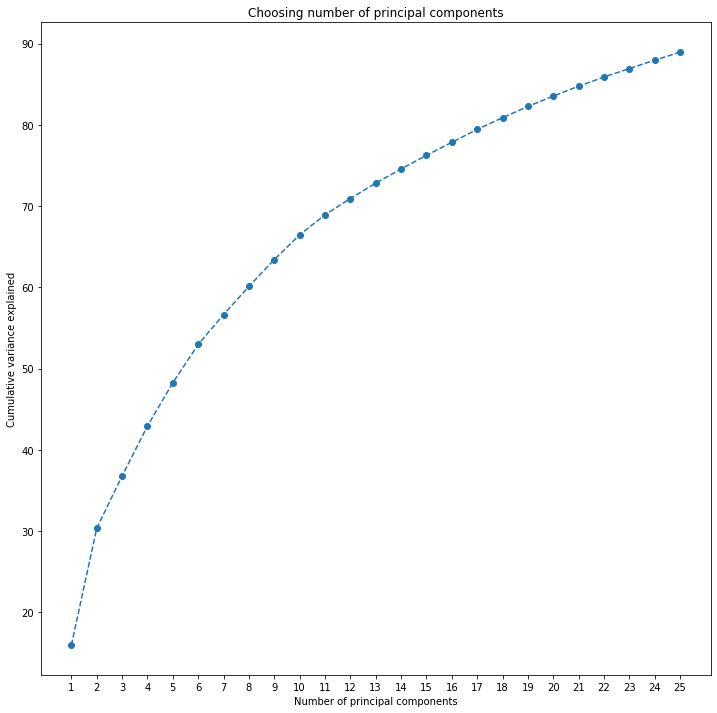

In [6]:
X_pca,cumu = pca(X_normalized,25)
fig = plt.figure(figsize=(12,12))
x_axis = [i+1 for i in range(25)]
xi = [i for i in range(25)]
fig = plt.figure(figsize=(12,12))

plt.xticks(xi,x_axis)
plt.plot(cumu,marker='o',linestyle='--')
plt.title("Choosing number of principal components")
plt.xlabel('Number of principal components')
plt.ylabel("Cumulative variance explained")
plt.show()

We will like to retain 90% of the variance explained in our dataset, therefore we will choose 25 principal components.

In [7]:
def find_cluster_size(feature_vec,epochs,max_cluster=15):   ##To determine the number of cluster
    cluster_cost=[]
    for i in range(1,max_cluster+1):
        
        cost_hist,cl = Kmean(X_pca,i,epochs)
        cluster_cost.append(cost_hist[-1])
        print("Cost of {} cluster is {}".format(i,cost_hist[-1]))
    return cluster_cost

cluster_cost = find_cluster_size(X_pca,10,10) ## random initialization of cluster 


Epoch 1 Current cost is 7802662.987197552
Epoch 2 Current cost is 6622227.883245618
Epoch 3 Current cost is 6622227.883245618
Epoch 4 Current cost is 6622227.883245618
Epoch 5 Current cost is 6622227.883245618
Epoch 6 Current cost is 6622227.883245618
Epoch 7 Current cost is 6622227.883245618
Epoch 8 Current cost is 6622227.883245618
Epoch 9 Current cost is 6622227.883245618
Epoch 10 Current cost is 6622227.883245618
Cost of 1 cluster is 6622227.883245618
Epoch 1 Current cost is 6549606.771467503
Epoch 2 Current cost is 5918733.859067228
Epoch 3 Current cost is 5914015.279586302
Epoch 4 Current cost is 5913849.691605843
Epoch 5 Current cost is 5913833.521412332
Epoch 6 Current cost is 5913831.193447117
Epoch 7 Current cost is 5913830.974015981
Epoch 8 Current cost is 5913830.961913328
Epoch 9 Current cost is 5913830.961228459
Epoch 10 Current cost is 5913830.961228459
Cost of 2 cluster is 5913830.961228459
Epoch 1 Current cost is 6638124.335416464
Epoch 2 Current cost is 5695038.872796

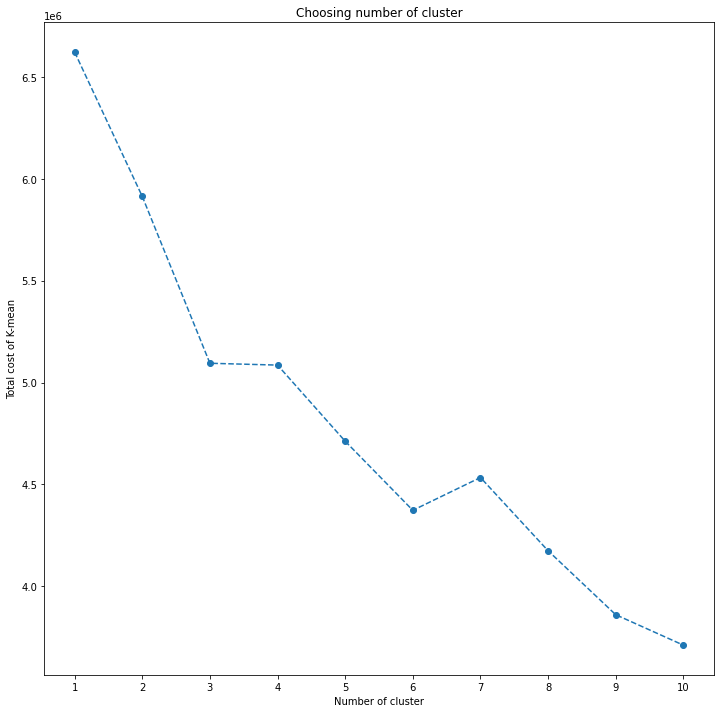

In [8]:
fig = plt.figure(figsize=(12,12))
plt.title("Choosing number of cluster")
x_axis = [i+1 for i in range(12)]
xi = [i for i in range(12)]
plt.xticks(xi,x_axis)
plt.plot(cluster_cost,marker='o',linestyle='--')
plt.xlabel('Number of cluster')
plt.ylabel('Total cost of K-mean')
plt.show()

Using the elbow method, we will choose 6 clusters.
We will then run multiple iterations of K mean to prevent being trap in a bad local minimum

In [9]:
## Multiple runs of the K-mean so that we don't get trap in a bad local minimum
def multi_fit(feature_vector,number_of_cluster,n_fits,epochs = 10):
    print("K-mean iteration 1")
    cost_hist,cl = Kmean(X_pca,number_of_cluster,epochs)
    min_cl = cl
    min_cost = cost_hist[-1]
    for i in range(1,n_fits):
        print('K-mean iteration {}'.format(i+1))
        cost_hist,cl = Kmean(feature_vector,number_of_cluster,epochs)
        if cost_hist[-1]<min_cost:
            min_cost = cost_hist[-1]
            min_cl = cl
        print("Current best fit cost : {} ".format(min_cost))
    return min_cost,min_cl

_,cl = multi_fit(X_pca,6,5,15)  ## Choose 6 cluster base on elbow method 

K-mean iteration 1
Epoch 1 Current cost is 5943748.644291457
Epoch 2 Current cost is 5167657.60423639
Epoch 3 Current cost is 5079716.346793117
Epoch 4 Current cost is 5024000.502199265
Epoch 5 Current cost is 4923508.571294743
Epoch 6 Current cost is 4740997.7404287625
Epoch 7 Current cost is 4613639.493208139
Epoch 8 Current cost is 4537110.766391526
Epoch 9 Current cost is 4473589.738509379
Epoch 10 Current cost is 4386668.296814643
Epoch 11 Current cost is 4324323.655177345
Epoch 12 Current cost is 4308640.132586611
Epoch 13 Current cost is 4304689.0323966965
Epoch 14 Current cost is 4302284.995173558
Epoch 15 Current cost is 4300472.287258368
K-mean iteration 2
Epoch 1 Current cost is 6043529.34442571
Epoch 2 Current cost is 5320899.764374859
Epoch 3 Current cost is 5191530.339133453
Epoch 4 Current cost is 5135065.39851933
Epoch 5 Current cost is 5062754.04761895
Epoch 6 Current cost is 4969433.955559787
Epoch 7 Current cost is 4852786.076208197
Epoch 8 Current cost is 4790045.44

In [10]:
##Add the cluster assigned to the dataframe
df_normalized['cluster'] = cl.astype(int)
num_cluster = len(set(cl))
df_normalized.head()

,new_deaths_tomorrow,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,cluster
location,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.171297,-0.146756,-0.161403,-0.162887,-0.156348,-0.174258,-0.574142,-0.419316,-0.491839,-0.541794,...,-1.163657,0.450144,-0.760877,-0.249731,-0.467288,-0.062479,-0.085585,-0.087436,-0.106969,0
Afghanistan,-0.171297,-0.146756,-0.161533,-0.162887,-0.156348,-0.174258,-0.574142,-0.419969,-0.491839,-0.541794,...,-1.163657,0.450144,-0.760877,-0.249731,-0.467288,-0.062479,-0.085585,-0.087436,-0.106969,0
Afghanistan,-0.171297,-0.146756,-0.161533,-0.162887,-0.156348,-0.174258,-0.574142,-0.419969,-0.491839,-0.541794,...,-1.163657,0.450144,-0.760877,-0.249731,-0.467288,-0.062479,-0.085585,-0.087436,-0.106969,0
Afghanistan,-0.171297,-0.146756,-0.161533,-0.162887,-0.156348,-0.174258,-0.574142,-0.419969,-0.491839,-0.541794,...,-1.163657,0.450144,-0.760877,-0.249731,-0.467288,-0.062479,-0.085585,-0.087436,-0.106969,0
Afghanistan,-0.171297,-0.146756,-0.161533,-0.162887,-0.156348,-0.174258,-0.574142,-0.419969,-0.491839,-0.541794,...,-1.163657,0.450144,-0.760877,-0.249731,-0.467288,-0.062479,-0.085585,-0.087436,-0.106969,0


# Data Visualization

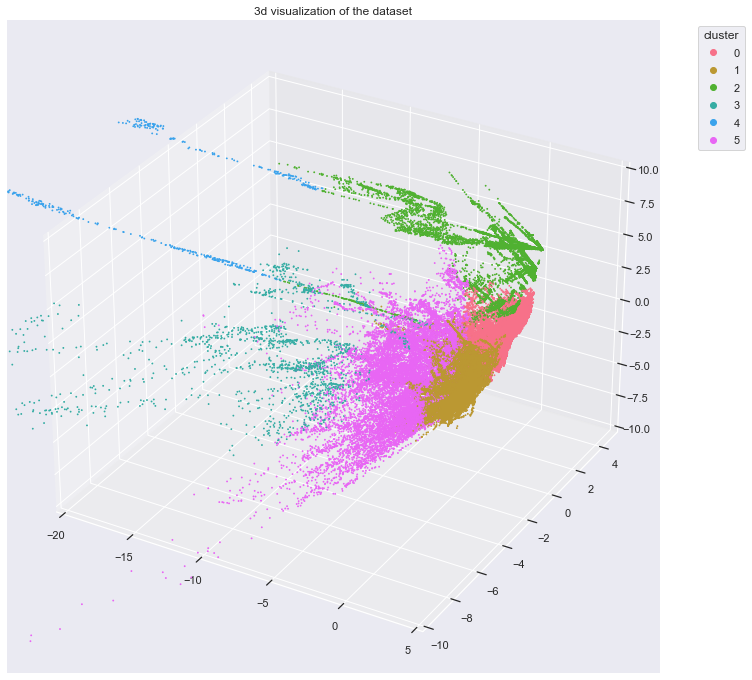

In [33]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
cmap = ListedColormap(sns.color_palette("husl", num_cluster).as_hex())
sc = ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],s=0.7, c=df_normalized['cluster'], marker='o', cmap=cmap, alpha=1)
plt.xlim(-20,5)
plt.ylim(-10,5)
ax.set_zlim(-10,10)
plt.title('3d visualization of the dataset')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2,title='cluster')

plt.show()


/Users/hung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, '2d visualization of the dataset')

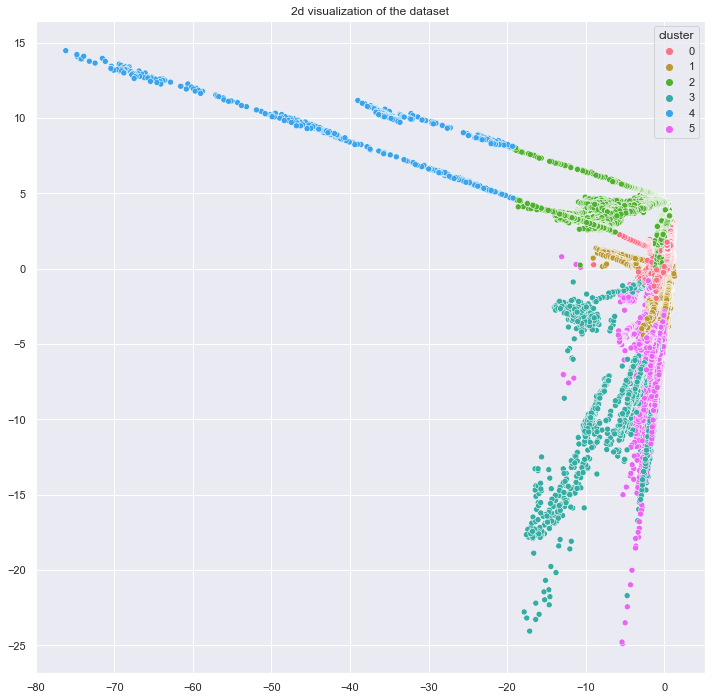

In [12]:

sns.set(rc={'figure.figsize':(12,12)})

sns.scatterplot(X_pca[:,0],X_pca[:,1],hue = df_normalized['cluster'],palette=sns.color_palette("husl", num_cluster))
plt.title('2d visualization of the dataset')

We will assign each country to a cluster number base on a majority rule which country X will be assigned to the cluster where most of its points belong in.

We will select countries with the highest cluster size.

In [13]:
## We will assign the cluster number to each country base on majority rule 
## Country X will be assigned to cluster Y if most of the country X points belong to cluster Y 
def majority(df_normalized):
    
    country_list = list(set(df_normalized.index))
    country_cluster_count = dict.fromkeys(country_list,(0,0))
    for group,frame in df_normalized.groupby(['location','cluster']):
        n_points = len(frame)
        if len(frame)>country_cluster_count[group[0]][1]:
            country_cluster_count[group[0]] = (group[1],n_points)
    return country_cluster_count 

def cluster_with_most_points(cl):
    
    m = 0
    n_cluster = len(set(cl))
    c_num = [0 for i in range(n_cluster)]
    for i in range(len(cl)):
        c_num[int(cl[i])]+=1
    return c_num

def get_country_cluster(country_cluster_count,cluster_num):
    country = []
    for key,value in country_cluster_count.items():
        if value[0]==cluster_num:
            country.append(key)
    return country

def get_countries_most_cluster(country_cluster_count,cl):
    points_per_cluster=[0 for i in range(len(set(cl)))]
    for i in cl:
        points_per_cluster[int(i)]+=1
    max_cluster = np.array(points_per_cluster)
    max_cluster_index = max_cluster.argmax()

    return get_country_cluster(country_cluster_count,max_cluster_index)


In [36]:
country_cluster_count = majority(df_normalized) 
country =  get_countries_most_cluster(country_cluster_count,cl) ## Pick the country with most country in the cluster
print(country)

['Mexico', 'Lesotho', 'Liechtenstein', 'Angola', 'Samoa', 'Syria', 'Belize', 'Tunisia', 'Djibouti', 'Honduras', 'Comoros', 'Saint Vincent and the Grenadines', 'Bolivia', 'Afghanistan', 'India', 'Equatorial Guinea', 'Sao Tome and Principe', 'Nicaragua', 'Azerbaijan', 'Kyrgyzstan', 'Bhutan', 'Saint Lucia', 'Vietnam', 'Benin', 'Indonesia', 'Ethiopia', 'Algeria', 'Ghana', 'Iran', 'Grenada', 'Papua New Guinea', 'Cape Verde', 'Chad', 'Tonga', 'Gabon', 'Iraq', 'Ecuador', 'Mauritania', 'Dominica', 'Laos', 'Maldives', 'Uzbekistan', 'Madagascar', 'Niger', 'Kiribati', 'Namibia', 'Bangladesh', 'Tanzania', 'Egypt', 'Eswatini', 'Guinea', 'Costa Rica', 'Uganda', 'Solomon Islands', 'Mozambique', 'Mongolia', 'Taiwan', 'Marshall Islands', 'Saint Kitts and Nevis', 'Dominican Republic', 'Eritrea', 'Haiti', 'South Sudan', 'Libya', 'Philippines', 'Cambodia', 'Paraguay', 'Rwanda', 'Jamaica', 'Congo', 'Burkina Faso', 'Guatemala', 'Palestine', 'Tajikistan', 'South Africa', 'Guyana', 'Armenia', 'Zimbabwe', 'New

In [15]:
feature_df = feature_df.reset_index()
mask = np.isin(feature_df['location'],np.array(country))
feature_df = feature_df[mask]
target_df = feature_df['new_deaths_tomorrow']
feature_vec = feature_df.drop(columns=['new_deaths_tomorrow','location'],axis=1)


In [16]:
def prepare_features(X):
    X = ((X-X.mean())/X.std())
    X = X.to_numpy()
    
    ones = np.ones((X.shape[0],1))
    X = np.concatenate((ones,X),axis=1)
    return X
def prepare_target(feature_vec):
    Y = feature_vec.to_numpy()
    Y = Y.reshape((len(Y),1))
    print(Y.shape)
    return Y
def gradient_descent(X,b,Y,alpha,epochs):
    J_hist = []
    for i in range(epochs):
        y_hat = np.matmul(X,b)
        derivate_error = (1/(X.shape[0])) * np.matmul(X.T, (np.matmul(X, b)-Y))
        b = b - alpha * derivate_error
        c = compute_cost(X,Y,b)
        J_hist.append(c)
            
        if i%500==0:
            print("Cost at {} iteration is : {}".format(i,c))
    return b,J_hist
def compute_cost(X, y, beta):
    J = 0
    m = len(y)
    y_hat = np.matmul(X,beta)
    
    J = 1/m *np.sum(np.square(y_hat-y))
    return J

def predict(x,b):
    return np.dot(x,b)

def gradient_descent(X,b,Y,alpha,epochs):
    J_hist = []
    for i in range(epochs):
        y_hat = np.matmul(X,b)
       # print(y_hat)
        c = compute_cost(X,Y,b)
        derivate_error = (1/(X.shape[0])) * np.matmul(X.T, (np.matmul(X, b)-Y))
        b = b - alpha * derivate_error
       
        J_hist.append(c)
            
        if i%100==0:
            print("Cost at {} iteration is : {}".format(i,c))
    print("Final cost: {}".format(J_hist[-1]))
    return b,J_hist

# Feature selection

We will use a selection technique method called forward selection in our feature selection. In each forward step, we will add the one variable that gives the single best improvement to our model. We will stop the loop when we have added 16 variable

In [19]:
def forward_selection(feature_vec,target_vec):

    selected = []
    cost_hist = []
    for i in range(18):
        min_cost = 999999
        min_feature= -1
        
        for j in range(59):
            if j-1 in selected:
                continue
            selected.append(j)
            feature_mask = np.isin(np.array([i for i in range(59)]),np.array(selected))
            X_f = prepare_features(feature_vec.loc[:,feature_mask])
            b = np.matmul(np.linalg.inv(np.matmul(X_f.T,X_f)),np.matmul(X_f.T,target_vec))
            c = compute_cost(X_f,Y,b)
            if c<min_cost:
                min_cost = c
                min_feature = j-1
            feature_vec.loc[:,feature_mask]
            selected.remove(j)
        selected.append(min_feature)
    selected.remove(-1)  ## removing the feature that correspond to the constant
    selected_feature_df = feature_vec.loc[:,feature_mask]
    
    return selected_feature_df,selected


In [21]:
Y = prepare_target(target_df)
selected_feature_df,selected = forward_selection(feature_vec,Y)
X = prepare_features(selected_feature_df)

           

(68327, 1)


In [22]:

print("Features selected : ",selected_feature_df.columns.to_numpy())

Features selected :  ['new_cases' 'total_deaths' 'new_deaths_smoothed'
 'new_cases_smoothed_per_million' 'new_deaths_per_million'
 'new_deaths_smoothed_per_million' 'new_tests' 'new_tests_per_thousand'
 'new_tests_smoothed_per_thousand' 'people_vaccinated' 'new_vaccinations'
 'people_vaccinated_per_hundred' 'stringency_index'
 'human_development_index' 'excess_mortality_cumulative_absolute'
 'excess_mortality']


# Training of our model

We will use gradient descent to train our model.

In [23]:
b = np.zeros((17,1))
b,J_hist = gradient_descent(X,b,Y,0.12,500)


Cost at 0 iteration is : 21361.739078256032
Cost at 100 iteration is : 2151.132295475887
Cost at 200 iteration is : 2129.8144996060246
Cost at 300 iteration is : 2128.7231768191136
Cost at 400 iteration is : 2128.65890519771
Final cost: 2128.6550660460066


Text(0, 0.5, 'Cost')

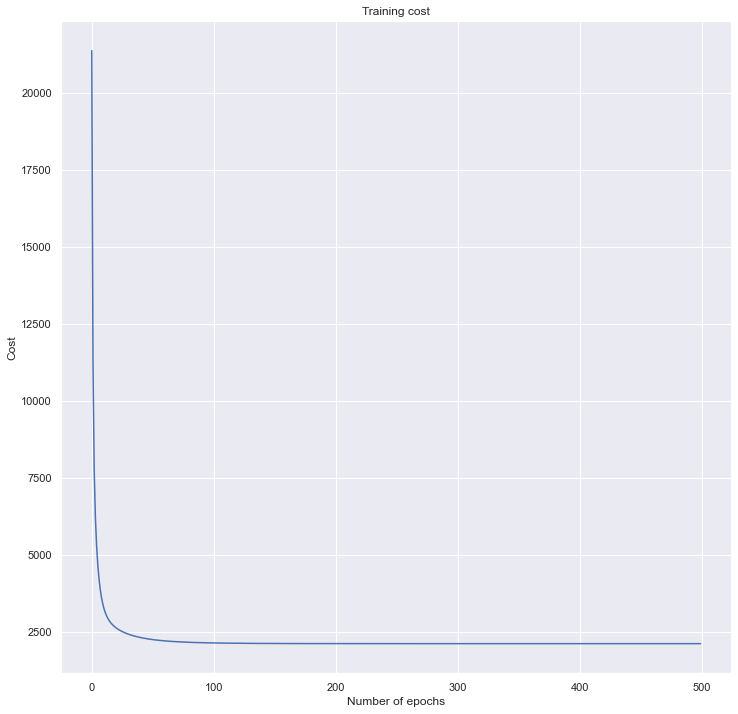

In [24]:
plt.plot(J_hist)
plt.title("Training cost")
plt.xlabel('Number of epochs')
plt.ylabel("Cost")

MSE error after training is 2128.655

# Model evaluation


In [25]:
def RMS(y_hat,Y):
    res = (y_hat-Y)**2
    return np.sqrt(np.sum(res)/len(Y))

def MAE(y_hat,Y):
    res = np.abs(y_hat-Y)
    return np.sum(res)/len(Y)

def MSE(y_hat,Y):
    res = (y_hat-Y)**2
    return np.sum(res)/len(Y)

In [29]:
y_hat = np.matmul(X,b)
res = Y-y_hat
rms = RMS(y_hat,Y)
mae = MAE(y_hat,Y)
mse = MSE(y_hat,Y)
print("Mean absolute error:",mae)
print("Mean squared error:",mse)
print("Root mean squared error:",rms)

Mean absolute error: 7.679552153820285
Mean squared error: 2128.655059037817
Root mean squared error: 46.13734993514275


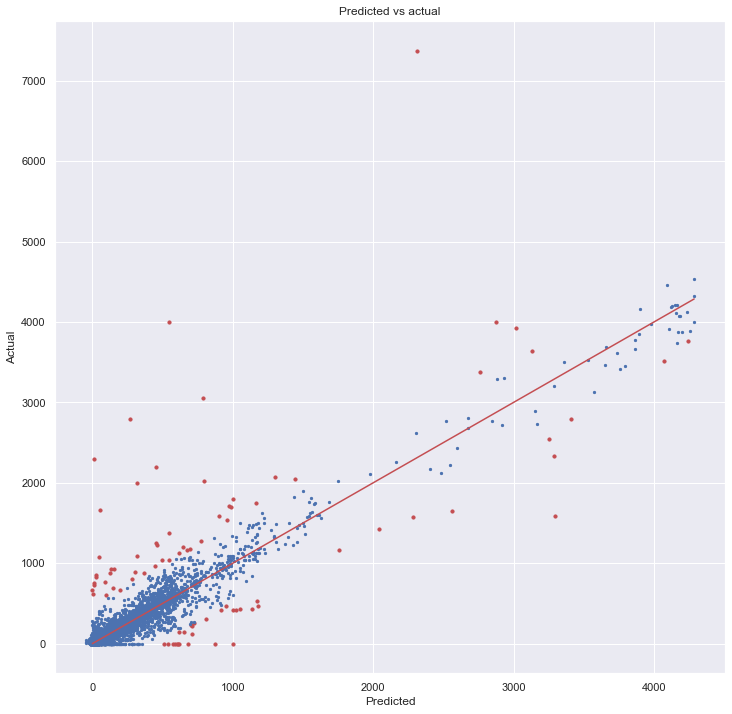

In [30]:
plt.figure()

x = [ i for i in range(int(max(y_hat)))]
y = [i for i in range(int(max(y_hat)))]

plt.scatter(y_hat[np.abs(res)>10*rms],Y[np.abs(res)>10*rms],s=10,c='r',label='Outlier')
plt.scatter(y_hat[np.abs(res)<10*rms],Y[np.abs(res)<10*rms],s=5)
plt.plot(x,y,color='r')
plt.title("Predicted vs actual")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Outlier is shown in red when the predicted vs actual difference is greater than 10 times the mean absolute error

In [1]:

plt.figure()
plt.title('Residual Plot')
x = [i for i in range(4219)]
y = [0 for i in range(4219)]
plt.plot(x,y,c='r')
plt.scatter(y_hat[np.abs(res)>10*rms],res[np.abs(res)>10*rms],s=10,c='r',label='Outlier')
plt.scatter(y_hat[np.abs(res)<10*rms],res[np.abs(res)<10*rms],s=5)

NameError: name 'plt' is not defined

Outlier is shown in red when the residual is greater than 10 times the root mean squared error

In [61]:
features_selected = selected_feature_df.columns.to_list()

In [62]:
features_selected.remove('new_cases_smoothed_per_million')
features_selected.remove('new_deaths_smoothed_per_million')
features_selected.remove('new_tests_smoothed_per_thousand')
features_selected.remove('human_development_index')
features_selected.remove('excess_mortality')

In [66]:
b

array([[ 2.53616286e+01],
       [ 2.52670492e+01],
       [ 8.26736440e+00],
       [ 1.17960847e+02],
       [ 2.83380401e-01],
       [-5.91577351e-01],
       [ 9.81896658e-02],
       [-1.03736100e+01],
       [ 6.70015441e-01],
       [-5.27813419e-01],
       [ 2.16019964e+00],
       [-3.52960572e+00],
       [-6.74896351e-01],
       [ 5.73445406e-01],
       [ 3.56783637e-01],
       [-6.26082888e+00],
       [ 9.08927596e-02]])